In [1]:
#Block 0: Environment & Config

import os, gc, random, time
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Settings (edit if needed)
force_cpu = False
IMG_SIZE = 128
BATCH_SIZE = 4
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
SEED = 42

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device selection
if force_cpu:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device selected:", device)

# Clean
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()


Device selected: cuda


In [2]:
# Block 1: Mount Drive & Paths
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# path to folder that contains individual image files (png/jpg)
IMAGES_DIR = "/content/drive/MyDrive/images_001/images"   # <--- edit if different

# verify
print("Checking image folder:", IMAGES_DIR)
if not os.path.exists(IMAGES_DIR):
    raise FileNotFoundError(f"Folder not found: {IMAGES_DIR}. Fix IMAGES_DIR in Block 1.")

# gather image files
image_files = sorted(
    glob(os.path.join(IMAGES_DIR, "*.png")) +
    glob(os.path.join(IMAGES_DIR, "*.jpg")) +
    glob(os.path.join(IMAGES_DIR, "*.jpeg"))
)
print(f"Total images found: {len(image_files)}")
if len(image_files) == 0:
    raise FileNotFoundError("No images found. Verify file types and folder content.")
print("Example files:", image_files[:5])


Mounted at /content/drive
Checking image folder: /content/drive/MyDrive/images_001/images
Total images found: 4999
Example files: ['/content/drive/MyDrive/images_001/images/00000001_000.png', '/content/drive/MyDrive/images_001/images/00000001_001.png', '/content/drive/MyDrive/images_001/images/00000001_002.png', '/content/drive/MyDrive/images_001/images/00000002_000.png', '/content/drive/MyDrive/images_001/images/00000003_000.png']


In [3]:
# ============================
# Block 2: Dataset (Poisson-only noise + normalization)
# ============================

class XrayDataset(Dataset):
    def __init__(self, paths, size=IMG_SIZE, poisson_peak=0.2):
        self.paths = list(paths)
        self.size = size
        self.poisson_peak = poisson_peak

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((self.size, self.size)),
            transforms.ToTensor()      # float32 in [0,1]
        ])

    def __len__(self):
        return len(self.paths)

    def add_poisson_noise(self, clean):
        clean_np = clean.numpy()                   # (1,H,W)

        # ---- Correct Poisson generation ----
        scaled = clean_np * (255.0 * self.poisson_peak)
        scaled = np.clip(scaled, 0, None)          # avoid negative

        scaled_int = scaled.astype(np.float32)

        # Sample Poisson
        noisy_counts = np.random.poisson(scaled_int)

        # Normalize back to [0,1]
        noisy = noisy_counts / (255.0 * self.poisson_peak + 1e-8)

        noisy = np.clip(noisy, 0.0, 1.0)

        return torch.from_numpy(noisy).float()

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("L")
        clean = self.transform(img)
        noisy = self.add_poisson_noise(clean)
        return noisy, clean

In [4]:
# ============================
# Block 3: split and dataloaders (75/10/15)
# ============================

random.shuffle(image_files)
n = len(image_files)
train_end = int(0.75 * n)
val_end = int(0.85 * n)

train_paths = image_files[:train_end]
val_paths = image_files[train_end:val_end]
test_paths = image_files[val_end:]

print("Split sizes -> train:", len(train_paths),
      "val:", len(val_paths),
      "test:", len(test_paths))

# Poisson-only dataset
train_ds = XrayDataset(train_paths, size=IMG_SIZE, poisson_peak=0.2)
val_ds   = XrayDataset(val_paths,   size=IMG_SIZE, poisson_peak=0.2)
test_ds  = XrayDataset(test_paths,  size=IMG_SIZE, poisson_peak=0.2)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)


Split sizes -> train: 3749 val: 500 test: 750


In [5]:
# Block 4: Improved DnCNN (optimized for 40dB+)
class DnCNN(nn.Module):
    def __init__(self, depth=20, n_channels=96, image_channels=1, residual_scaling=0.1):
        super(DnCNN, self).__init__()
        self.residual_scaling = residual_scaling

        layers = []
        layers.append(nn.Conv2d(image_channels, n_channels, kernel_size=3, padding=1, bias=True))
        layers.append(nn.LeakyReLU(0.1, inplace=True))

        for _ in range(depth - 2):
            layers.append(nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.LeakyReLU(0.1, inplace=True))

        layers.append(nn.Conv2d(n_channels, image_channels, kernel_size=3, padding=1, bias=True))
        self.net = nn.Sequential(*layers)

        # Kaiming initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        residual = self.net(x)
        out = x - self.residual_scaling * residual
        return torch.clamp(out, 0.0, 1.0)


model = DnCNN(depth=20, n_channels=96, image_channels=1).to(device)
print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)


Model params (M): 1.498273


In [6]:
# ============================
# Block 5: Loss + Optimizer + Scheduler
# ============================

# MUST be defined before scheduler
EPOCHS = 25
LEARNING_RATE = 1e-3

# ---- SSIM loss ----
def ssim_loss(pred, target, C1=0.01**2, C2=0.03**2):
    mu_x = F.avg_pool2d(pred, 3, 1, 1)
    mu_y = F.avg_pool2d(target, 3, 1, 1)

    sigma_x = F.avg_pool2d(pred * pred, 3, 1, 1) - mu_x * mu_x
    sigma_y = F.avg_pool2d(target * target, 3, 1, 1) - mu_y * mu_y
    sigma_xy = F.avg_pool2d(pred * target, 3, 1, 1) - mu_x * mu_y

    ssim_map = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / (
              (mu_x * mu_x + mu_y * mu_y + C1) * (sigma_x + sigma_y + C2))
    return 1 - ssim_map.mean()

# ---- Hybrid Loss: MSE (PSNR) + SSIM ----
class HybridLoss(nn.Module):
    def __init__(self, alpha=0.95):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        return self.alpha * self.mse(pred, target) + (1 - self.alpha) * ssim_loss(pred, target)

criterion = HybridLoss(alpha=0.95)

# ---- Optimizer ----
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-6
)

# ---- LR Scheduler ----
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-6
)

# ---- AMP ----
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# ---- Gradient Clipping ----
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

print("Block 5 Ready ✔")


Block 5 Ready ✔


/tmp/ipython-input-134700871.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [7]:
# Block 6: metrics
def calc_mse_torch(pred, target):
    return F.mse_loss(pred, target, reduction='mean').item()

def calc_psnr_torch(pred, target):
    mse = F.mse_loss(pred, target, reduction='mean')
    if mse == 0:
        return float('inf')
    return (20 * torch.log10(1.0 / torch.sqrt(mse))).item()


In [8]:
# ============================
# Block 7: Training Loop (Fixed)
# ============================

import torch.nn.functional as F   # <-- FIXED

best_val_psnr = -1.0
best_val_mse = 1e12
best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_mse = 0.0
    running_psnr = 0.0
    count = 0

    for noisy, clean in train_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast("cuda", enabled=use_amp):   # <-- FIXED
            out = model(noisy)
            loss = criterion(out, clean)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_gradients(model, max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        batch_mse = F.mse_loss(out, clean, reduction='mean').item()
        batch_psnr = calc_psnr_torch(out, clean)

        running_loss += loss.item()
        running_mse += batch_mse
        running_psnr += batch_psnr
        count += 1

    train_loss = running_loss / count
    train_mse = running_mse / count
    train_psnr = running_psnr / count





    # -------- Validation --------
    model.eval()
    v_loss = 0.0
    v_mse = 0.0
    v_psnr = 0.0
    v_count = 0

    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy = noisy.to(device)
            clean = clean.to(device)

            out = model(noisy)
            loss_v = criterion(out, clean)

            batch_mse = F.mse_loss(out, clean, reduction='mean').item()
            batch_psnr = calc_psnr_torch(out, clean)

            v_loss += loss_v.item()
            v_mse += batch_mse
            v_psnr += batch_psnr
            v_count += 1

    val_loss = v_loss / v_count
    val_mse = v_mse / v_count
    val_psnr = v_psnr / v_count

    scheduler.step()

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.6f} | Train MSE: {train_mse:.6e} | Train PSNR: {train_psnr:.2f} dB")
    print(f"                 Val   Loss: {val_loss:.6f} | Val   MSE: {val_mse:.6e} | Val   PSNR: {val_psnr:.2f} dB")

    # ---- Save Best Model ----
    save_model = False
    if val_psnr > best_val_psnr + 1e-3:
        save_model = True
    elif abs(val_psnr - best_val_psnr) <= 1e-3 and val_mse < best_val_mse:
        save_model = True

    if save_model:
        best_val_psnr = val_psnr
        best_val_mse = val_mse
        best_epoch = epoch
        torch.save(model.state_dict(), "best_dncnn.pth")
        print(f"Saved best model at epoch {epoch} | Val PSNR: {val_psnr:.2f} | Val MSE: {val_mse:.6e}")

Epoch 1/25 | Train Loss: 0.009429 | Train MSE: 1.252018e-03 | Train PSNR: 29.85 dB
                 Val   Loss: 0.007369 | Val   MSE: 8.699477e-04 | Val   PSNR: 30.64 dB
Saved best model at epoch 1 | Val PSNR: 30.64 | Val MSE: 8.699477e-04
Epoch 2/25 | Train Loss: 0.006588 | Train MSE: 7.175400e-04 | Train PSNR: 31.48 dB
                 Val   Loss: 0.006216 | Val   MSE: 6.785778e-04 | Val   PSNR: 31.71 dB
Saved best model at epoch 2 | Val PSNR: 31.71 | Val MSE: 6.785778e-04
Epoch 3/25 | Train Loss: 0.005983 | Train MSE: 6.507773e-04 | Train PSNR: 31.89 dB
                 Val   Loss: 0.005660 | Val   MSE: 6.378968e-04 | Val   PSNR: 31.97 dB
Saved best model at epoch 3 | Val PSNR: 31.97 | Val MSE: 6.378968e-04
Epoch 4/25 | Train Loss: 0.005681 | Train MSE: 6.244031e-04 | Train PSNR: 32.07 dB
                 Val   Loss: 0.005503 | Val   MSE: 6.136228e-04 | Val   PSNR: 32.15 dB
Saved best model at epoch 4 | Val PSNR: 32.15 | Val MSE: 6.136228e-04
Epoch 5/25 | Train Loss: 0.005561 | Trai

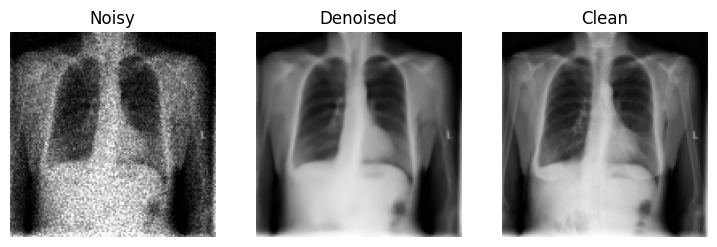

In [9]:
# ============================
# Block 9: Visual Results
# ============================

model.load_state_dict(torch.load("best_dncnn.pth", map_location=device))
model.eval()

noisy, clean = next(iter(test_loader))

noisy = noisy.to(device)
clean = clean.to(device)

with torch.no_grad():
    out = model(noisy)

noisy_np = noisy[0][0].cpu().numpy()
out_np = out[0][0].cpu().numpy()
clean_np = clean[0][0].cpu().numpy()

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(noisy_np, cmap='gray'); plt.title("Noisy"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(out_np, cmap='gray'); plt.title("Denoised"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(clean_np, cmap='gray'); plt.title("Clean"); plt.axis('off')
plt.show()


In [10]:
# Block 8: Post-training quantisation (block mean) and evaluation on test set
def quantize_block_mean(img_np, block=4):
    H, W = img_np.shape
    H_new = H - (H % block)
    W_new = W - (W % block)
    img = img_np[:H_new, :W_new]
    quant = np.zeros_like(img)
    for i in range(0, H_new, block):
        for j in range(0, W_new, block):
            patch = img[i:i+block, j:j+block]
            mean_val = patch.mean()
            quant[i:i+block, j:j+block] = mean_val
    return quant

# Evaluate quantization effect and final PSNR/MSE
model.load_state_dict(torch.load("best_dncnn.pth", map_location=device))
model.eval()

test_mse_fp32 = []
test_psnr_fp32 = []
test_mse_quant = []
test_psnr_quant = []

with torch.no_grad():
    for noisy, clean in test_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)
        out = model(noisy)
        out_np = out[0][0].cpu().numpy()
        clean_np = clean[0][0].cpu().numpy()

        # FP32 metrics
        mse_fp32 = np.mean((out_np - clean_np)**2)
        psnr_fp32 = 10 * np.log10(1.0 / mse_fp32) if mse_fp32 > 0 else float('inf')

        # quantize denoised output (block mean)
        quant_np = quantize_block_mean(out_np, block=4)
        # align clean for trimmed size
        clean_trim = clean_np[:quant_np.shape[0], :quant_np.shape[1]]
        mse_q = np.mean((quant_np - clean_trim)**2)
        psnr_q = 10 * np.log10(1.0 / mse_q) if mse_q > 0 else float('inf')

        test_mse_fp32.append(mse_fp32)
        test_psnr_fp32.append(psnr_fp32)
        test_mse_quant.append(mse_q)
        test_psnr_quant.append(psnr_q)

print("Test FP32 Avg MSE:", np.mean(test_mse_fp32), "Avg PSNR:", np.mean(test_psnr_fp32))
print("Test Quantized Avg MSE:", np.mean(test_mse_quant), "Avg PSNR:", np.mean(test_psnr_quant))


Test FP32 Avg MSE: 0.0004790718 Avg PSNR: 33.3243
Test Quantized Avg MSE: 0.0023962175 Avg PSNR: 26.839699


=== Quantisation Results ===
Block size:              4x4
MSE after quantisation:  0.003157
PSNR after quantisation: 25.007 dB
Compression ratio:       0.50:1


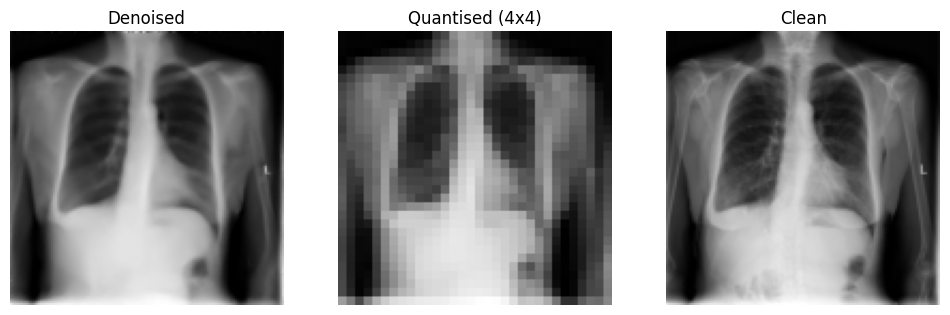

In [12]:
# ---------------------------
# Block 11: Metrics and Quantised Output
# ---------------------------
import math
import numpy as np
import matplotlib.pyplot as plt

# --- MSE & PSNR ---
def mse(original, quantized):
    return np.mean((original - quantized) ** 2)

def psnr(original, quantized):
    m = mse(original, quantized)
    if m == 0:
        return float('inf')
    return 10 * math.log10(1.0 / m)   # images scaled 0–1

# --- Compression ratio ---
def compression_ratio(block):
    return 8 / (1 * block * block)  # 8 bits → 1 value per block

# --- Grayscale Block Quantization ---
def quantize_grayscale(img, block=4):
    """
    img: numpy array scaled [0,1]
    block: block size for quantization
    """
    h, w = img.shape
    quant = img.copy()
    for i in range(0, h, block):
        for j in range(0, w, block):
            block_val = np.mean(img[i:i+block, j:j+block])
            quant[i:i+block, j:j+block] = block_val
    return quant

# --- Take a sample ---
model.eval()
noisy, clean = next(iter(test_loader))

with torch.no_grad():
    noisy = noisy.to(device)
    denoised = model(noisy)

# Convert to numpy
clean_np = clean[0][0].cpu().numpy()
den_np = denoised[0][0].cpu().numpy()

# --- Quantisation ---
block = 4
quant_np = quantize_grayscale(den_np, block=block)

# --- Metrics ---
mse_val = mse(clean_np, quant_np)
psnr_val = psnr(clean_np, quant_np)
cr = compression_ratio(block)

print("=== Quantisation Results ===")
print(f"Block size:              {block}x{block}")
print(f"MSE after quantisation:  {mse_val:.6f}")
print(f"PSNR after quantisation: {psnr_val:.3f} dB")
print(f"Compression ratio:       {cr:.2f}:1")

# --- Visualization ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(den_np, cmap='gray');  plt.title("Denoised"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(quant_np, cmap='gray'); plt.title(f"Quantised ({block}x{block})"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(clean_np, cmap='gray'); plt.title("Clean"); plt.axis('off')
plt.show()
